In [1]:
#Transfer Learning with Tensorflow

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-09 02:17:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-09 02:17:57 (52.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#import helper functions we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 if you are running this notebook in google colab, when it times out colab will delete helper_functions.py , so you'll have to redownload it if you want access to your helper funcitions.

#let's get some data
This time we are going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/2_datas_2_Class"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



There are 2 directories and 0 images in '/content/drive/MyDrive/2_datas_2_Class'.
There are 2 directories and 0 images in '/content/drive/MyDrive/2_datas_2_Class/Test'.
There are 0 directories and 107 images in '/content/drive/MyDrive/2_datas_2_Class/Test/Benign'.
There are 0 directories and 144 images in '/content/drive/MyDrive/2_datas_2_Class/Test/Malignant'.
There are 2 directories and 0 images in '/content/drive/MyDrive/2_datas_2_Class/Train'.
There are 0 directories and 3568 images in '/content/drive/MyDrive/2_datas_2_Class/Train/Benign'.
There are 0 directories and 3796 images in '/content/drive/MyDrive/2_datas_2_Class/Train/Malignant'.


In [4]:
train_dir = "/content/drive/MyDrive/2_datas_2_Class/Train"
test_dir = "/content/drive/MyDrive/2_datas_2_Class/Test"

In [5]:
import tensorflow as tf
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_data= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                          label_mode="binary",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                          label_mode="binary",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 7364 files belonging to 2 classes.
Found 251 files belonging to 2 classes.


In [6]:
train_data.class_names

['Benign', 'Malignant']

In [10]:
#see an example of a batch of data
for images, labels in train_data.take(1):
  print(images, labels)


tf.Tensor(
[[[[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  ...

  [[ 73.        73.        73.      ]
   [ 81.        81.        81.      ]
   [ 81.        81.        81.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[ 78.        78.        78.    

#### Building a feature extraction model with the Keras Functional API

In [8]:
# 1.  create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. if using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)

# 8. compile the model
model_0.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 9. fit the model
history_0 = model_0.fit(train_data,
                        epochs=40,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240509-021913
Epoch 1/40
231/231 [==============================] - 509s 2s/step - loss: 0.6638 - accuracy: 0.5927 - val_loss: 0.6725 - val_accuracy: 0.7031
Epoch 2/40
231/231 [==============================] - 25s 103ms/step - loss: 0.6172 - accuracy: 0.6597 - val_loss: 0.6394 - val_accuracy: 0.6875
Epoch 3/40
231/231 [==============================] - 25s 104ms/step - loss: 0.6028 - accuracy: 0.6748 - val_loss: 0.6000 - val_accuracy: 0.7188
Epoch 4/40
231/231 [==============================] - 25s 103ms/step - loss: 0.5937 - accuracy: 0.6794 - val_loss: 0.6794 - val_accuracy: 0.6094
Epoch 5/40
231/231 [==============================] - 24s 102ms/step - loss: 0.5847 - accuracy: 0.6927 - val_loss: 0.5994 - val_accuracy: 0.7031
Epoch 6/40
231/231 [==============================] - 24s 102ms/s

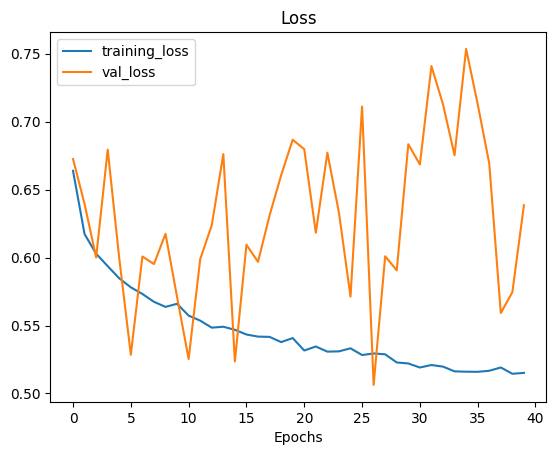

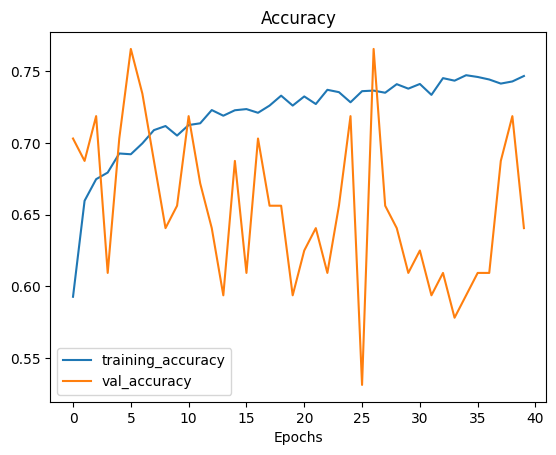

In [9]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_0)

In [10]:
from google.colab import files

# Not defterini indirme işlemi
files.download("09.05.2024.ipynb")


FileNotFoundError: Cannot find file: 09.05.2024.ipynb